In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os, pickle
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar, minimize_scalar
from scipy.ndimage import gaussian_filter
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec

from src.model import intensity, create_connect_mat
from src.theory import rate_fn, rate_fn_neg
from src.sim import sim_lif_perturbation, sim_lif_receptor_perturbation, sim_lif_perturbation_x, sim_lif_pop, create_spike_train, sim_determ_lif_recep
from src.phase_plane import dv, phase_plane_plot

In [3]:
from scripts.prob_decision import *

In [4]:
connect_prob_doiron = np.array([[0.03, 0.1, 0.1],
                                [0.05, 0.1, 0.07],
                                [0.05, 0, 0]])

N_doiron = np.array([[4136, 904, 750]]).T

Ned = 4136
Npd = 904
Nsd = 750

Npd_idx = Ned + Npd
Nsd_idx = Ned + Npd + Nsd

fNse = int(0.15 * Ned)

Nid = Npd + Nsd

In [28]:
np.ones((3,3)).sum()

np.float64(9.0)

In [27]:
connect_prob_doiron.sum()

np.float64(0.5)

### Cell Type Params

In [20]:
c_d = np.zeros((N_doiron.sum(), N_doiron.sum()))
c_d.shape

(5790, 5790)

In [38]:
# excitatory to excitatory
c_d[:Ned,:Ned] = np.random.binomial(n=1,
                                    p=connect_prob_doiron[0,0],
                                    size=(Ned,Ned))

# excitatory to pv
c_d[Ned:Npd_idx,:Ned] = np.random.binomial(n=1,
                                           p=connect_prob_doiron[1,0],
                                           size=(Npd,Ned))

# excitatory to sst
c_d[Npd_idx:Nsd_idx,:Ned] = np.random.binomial(n=1,
                                               p=connect_prob_doiron[2,0],
                                               size=(Nsd,Ned))

# pv to excitatory
c_d[:Ned,Ned:Npd_idx] = np.random.binomial(n=1,
                                           p=connect_prob_doiron[0,1],
                                           size=(Ned,Npd))

# pv to pv
c_d[Ned:Npd_idx,Ned:Npd_idx] = np.random.binomial(n=1,
                                                  p=connect_prob_doiron[1,1],
                                                  size=(Npd,Npd))

# sst to excitatory
c_d[:Ned,Npd_idx:Nsd_idx] = np.random.binomial(n=1,
                                               p=connect_prob_doiron[0,2],
                                               size=(Ned,Nsd))

# sst to pv
c_d[Ned:Npd_idx,Npd_idx:Nsd_idx] = np.random.binomial(n=1,
                                                      p=connect_prob_doiron[1,2],
                                                      size=(Npd,Nsd))

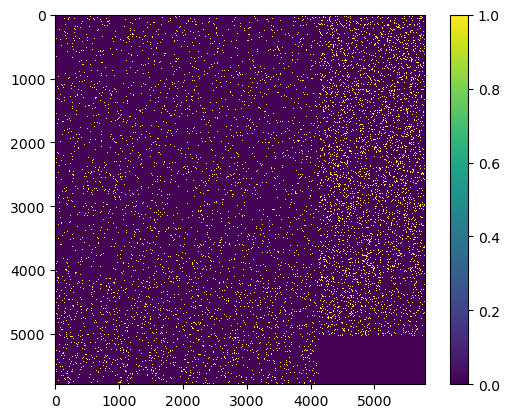

In [257]:
plt.imshow(c_d, interpolation='nearest')
plt.colorbar()

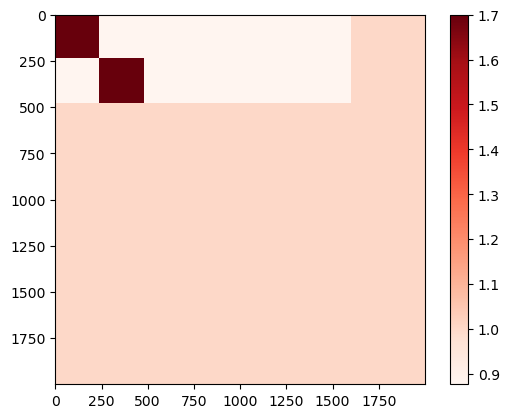

In [22]:
Jmat_fc = create_connect_mat(1600, 400, 0.15, 1.7, plot=True)

In [30]:
connect_prob_huang = np.array([[0.1, 0.04, 0.03, 0],
                               [0.03, 0.04, 0.03, 0],
                               [0.03, 0, 0, 0.1],
                               [0.01, 0, 0.1, 0]])

N_huang = np.array([[40, 4, 4, 2]]).T

## Simulations

A mean rate: 37.44 Hz
B mean rate: 42.56 Hz
Stimulation length: 2 s
Simulating network of 2000 neurons


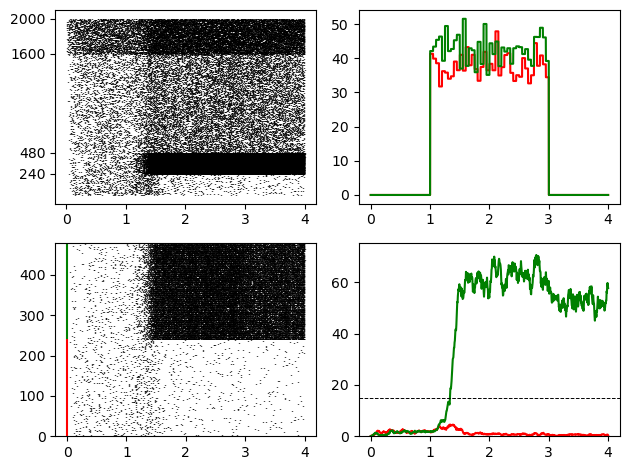

In [18]:
lif_sim,sens_input,firing_rates,reaction_time = produce_prob_decision(mu_0=40, coh=-6.4, stim_len=2)

A mean rate: 19.519999999999996 Hz
B mean rate: 60.480000000000004 Hz
Stimulation length: 2 s
Simulating network of 5790 neurons


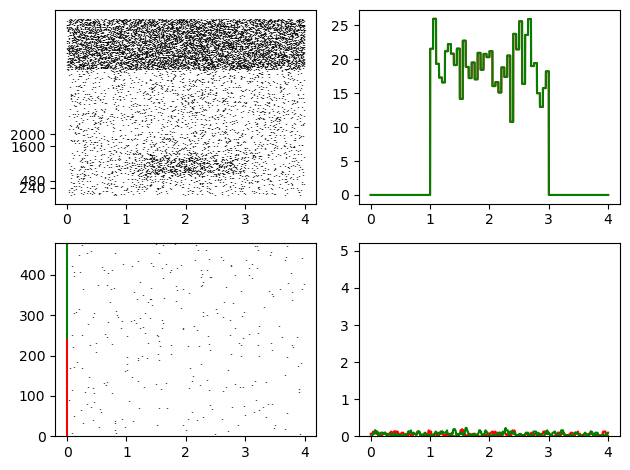

In [5]:
# doiron parameters
lif_sim,sens_input,firing_rates,reaction_time = produce_prob_decision(mu_0=40, coh=-51.2, stim_len=2, Ne=Ned, Ni=Nid)

In [7]:
spktimes = lif_sim['spike_times']
tplot = np.arange(0,4,0.0001)
stim_rates = sens_input['rates']
tplot_rt = np.linspace(0,4,len(firing_rates['A']))
firing_rate_A = firing_rates['A']
firing_rate_B = firing_rates['B']

In [16]:
fNe = 620
fNe2 = 1240
spktrains = lif_sim['spike_trains']

dt = 0.0001

sum_spks_A = spktrains[:,:fNe].sum(axis=1) # sel for A
sum_spks_B = spktrains[:,fNe:fNe2].sum(axis=1)

tstep = int(0.005 / dt) # 5 ms step
twindow = int(0.05 / dt) # 50 ms window length

window_spks_A = sliding_window_view(sum_spks_A, window_shape=twindow)
window_spks_B = sliding_window_view(sum_spks_B, window_shape=twindow)

firing_rate_A = window_spks_A[::tstep].sum(axis=1) / (fNe) / twindow / dt
firing_rate_B = window_spks_B[::tstep].sum(axis=1) / (fNe) / twindow / dt

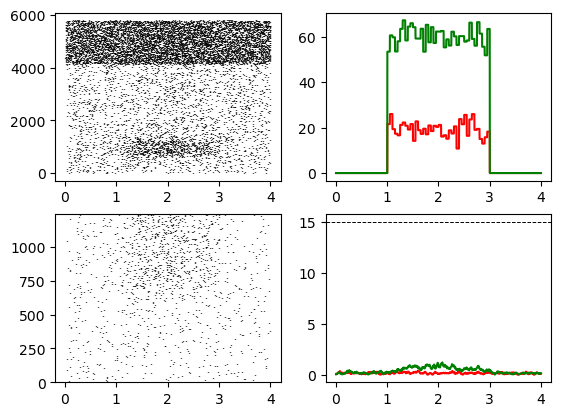

In [17]:
fig, ax = plt.subplots(2,2)

    # plot all spikes, edit out later
ax[0,0].plot(spktimes[:,0], spktimes[:,1], 'k|', markersize=0.5)
#ax[0,0].set_yticks([240, 480, 1600, 2000])

# plot sensory input
ax[0,1].plot(tplot, stim_rates[:,0], color='r')
ax[0,1].plot(tplot, stim_rates[:,1000], color='g')

# plot spike times of selective populations
ax[1,0].plot(spktimes[:,0], spktimes[:,1], 'k|', markersize=0.5)
ax[1,0].set_ylim((0,1240))

# plot firing rates
ax[1,1].plot(tplot_rt, firing_rate_A, color='r')
ax[1,1].plot(tplot_rt, firing_rate_B, color='g')
ax[1,1].axhline(15, linewidth='0.7', color='k', linestyle='--')

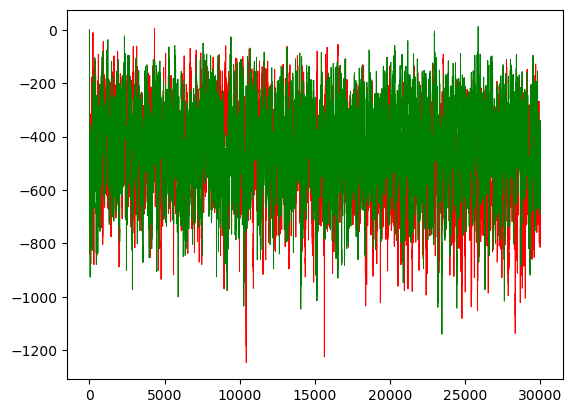

In [176]:
recep = 'total'

plt.plot(lif_sim['syn_currents'][recep][:30000,200], color='r', linewidth=0.7)
plt.plot(lif_sim['syn_currents'][recep][:30000,400], color='g', linewidth=0.7)

In [ ]:
lif_sim['spike_trains'][:,300].sum()

np.float64(3.0)

In [136]:
lif_sim['spike_trains'][20000:30000,200].sum()

np.float64(42.0)

In [274]:
fNe = 240